In [1]:
import torch
import sklearn
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math

from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D, MaxPool2D, Dropout,Flatten, Conv1D, MaxPool1D, LSTM, TimeDistributed, RepeatVector
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split

import time
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import signal
import math
import matplotlib.pyplot as plt
import json
import math


In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)): 
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i]) 
        dataY.append(d_y[i + fore_cast,:])
    
    return np.array(dataX), np.array(dataY)

In [5]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\JJ\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [6]:
#inclined_files = ['SKS_2_I.xlsx',  'SKS_3_I.xlsx',  'SKS_4_I.xlsx','SKS_5_I.xlsx', 'SD_2_I.xlsx',  'SD_3_I.xlsx',  'SD_4_I.xlsx','SD_5_I.xlsx']
#file_name = ['TH_4_I.xls', 'TH_2_I.xls', 'TH_3_I.xls']

# Subj TH:
#file_name = ['TH_4_I_r.xlsx', 'TH_2_I_r.xlsx', 'TH_3_I_r.xlsx']

# Subj JJ:
#file_name = ['JJ_4_I.xlsx', 'JJ_6_I.xlsx', 'JJ_7_I.xlsx']
file_name = ['JJ_4_I_r.xlsx', 'JJ_6_I_r.xlsx', 'JJ_7_I_r.xlsx']

# Subj SD:
#file_name = ['SD_1_I_r.xls', 'SD_4_I_r.xls', 'SD_2_I_r.xls', 'SD_3_I_r.xls', 'SD_5_I_r.xls']

# Subj PK:
#file_name = ['PK_0_I_r.xls', 'PK_5_I_r.xls', 'PK_2_I_r.xls', 'PK_3_I_r.xls']

# Subj SKS:
#file_name = ['SKS_0_I_r.xls', 'SKS_4_I_r.xls', 'SKS_2_I_r.xls', 'SKS_3_I_r.xls', 'SKS_5_I_r.xls']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173247 entries, 0 to 173246
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      173247 non-null  float64
 1   l_ph_ank      173247 non-null  float64
 2   l_ph_fo       173247 non-null  float64
 3   r_ph_hip      173247 non-null  float64
 4   r_ph_ank      173247 non-null  float64
 5   r_ph_fo       173247 non-null  float64
 6   n_lgrf        173247 non-null  float64
 7   n_r_grf       173247 non-null  float64
 8   n_lcop        173247 non-null  float64
 9   n_rcop        173247 non-null  float64
 10  perc_new      173247 non-null  float64
 11  st_sw_phase   173247 non-null  int64  
 12  strike_frame  173247 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 17.2 MB


In [8]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table
        

,l_ph_hip,l_ph_ank,l_ph_fo,r_ph_hip,r_ph_ank,r_ph_fo,n_lgrf,n_r_grf,n_lcop,n_rcop,perc_new,st_sw_phase,strike_frame
0,0.013794,0.981803,0.668248,0.201302,0.461253,0.029672,0.892821,0.033906,-0.000203,0.149024,0.000000,1,1
1,0.015795,0.988821,0.653193,0.195847,0.461295,0.032127,0.896607,0.052733,-0.000088,0.175505,0.469484,1,2
2,0.017680,0.996066,0.639395,0.189223,0.460531,0.034570,0.896830,0.075863,0.000005,0.203714,0.938967,1,3
3,0.019452,0.003508,0.627022,0.180969,0.458955,0.036968,0.893287,0.102803,0.000080,0.233299,1.408451,1,4
4,0.021115,0.011113,0.616171,0.170377,0.456572,0.039293,0.885878,0.132649,0.000139,0.263786,1.877934,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172187,0.497703,0.131429,0.994877,0.020622,0.846765,0.977150,0.771417,0.000000,-0.000662,0.038901,97.609562,0,246
172188,0.495738,0.122350,0.996610,0.020075,0.840985,0.978844,0.771872,0.000000,-0.000494,0.052176,98.007968,0,247
172189,0.493823,0.111011,0.998418,0.019466,0.834862,0.980856,0.772048,0.000000,-0.000349,0.067309,98.406375,0,248
172190,0.491936,0.096736,0.000285,0.018791,0.828544,0.983206,0.772066,0.000000,-0.000225,0.084342,98.804781,0,249


In [9]:
source_table = source_table.drop(["n_lgrf","n_r_grf", "l_ph_ank", "r_ph_ank", "l_ph_fo", "r_ph_fo", "st_sw_phase"], axis = 1)
source_table

,l_ph_hip,r_ph_hip,n_lcop,n_rcop,perc_new,strike_frame
0,0.013794,0.201302,-0.000203,0.149024,0.000000,1
1,0.015795,0.195847,-0.000088,0.175505,0.469484,2
2,0.017680,0.189223,0.000005,0.203714,0.938967,3
3,0.019452,0.180969,0.000080,0.233299,1.408451,4
4,0.021115,0.170377,0.000139,0.263786,1.877934,5
...,...,...,...,...,...,...
172187,0.497703,0.020622,-0.000662,0.038901,97.609562,246
172188,0.495738,0.020075,-0.000494,0.052176,98.007968,247
172189,0.493823,0.019466,-0.000349,0.067309,98.406375,248
172190,0.491936,0.018791,-0.000225,0.084342,98.804781,249


In [10]:
source_table.info()
source_table.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172192 entries, 0 to 172191
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      172192 non-null  float64
 1   r_ph_hip      172192 non-null  float64
 2   n_lcop        172192 non-null  float64
 3   n_rcop        172192 non-null  float64
 4   perc_new      172192 non-null  float64
 5   strike_frame  172192 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 7.9 MB


,count,mean,std,min,25%,50%,75%,max
l_ph_hip,172192.0,0.434026,0.394665,5.283210e-07,0.035722,0.308568,0.933308,1.000000
r_ph_hip,172192.0,0.445185,0.314283,2.253369e-06,0.222619,0.374725,0.729080,1.000000
n_lcop,172192.0,0.112641,0.174122,-2.209547e-02,-0.000095,0.000447,0.215479,0.618878
n_rcop,172192.0,0.114187,0.176876,-2.145577e-02,-0.000163,0.000450,0.220535,0.603843
perc_new,172192.0,49.544459,28.733103,0.000000e+00,24.655941,49.541284,74.418605,99.526066
strike_frame,172192.0,109.680676,64.045994,1.000000e+00,55.000000,109.000000,163.000000,271.000000


In [11]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [12]:
#x = x.drop(['r_ph_foot'], axis=1)
#x = x.drop(['r_ph_hip'], axis=1)

In [13]:
data_y = y.values.reshape(-1,2)

In [14]:
type(data_y)

numpy.ndarray

In [15]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25, 
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [16]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)

(129133, 10, 5)
(129133, 2)
(43037, 10, 5)
(43037, 2)


In [17]:
print(train_x.shape)
print(validation_x.shape)

(129133, 10, 5)
(43037, 10, 5)


In [18]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        curLR = optimizer.lr
        return curLR
    return lr

In [19]:
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.layers import Input, Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.metrics import mean_squared_error

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [20]:
import tensorflow.keras.layers as L
epochs = 30
batch_size = 64                                                                
learning_rate = 1e-2

# learning rate scheduler
use_lr_scheduler = True
lr_factor = 0.5
lr_patience = 8
lr_threshold = 0.01
lr_min_rate = 1e-6


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.1)
#optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = Sequential()
model.add((Conv1D(50, kernel_size=2, strides=1,input_shape=(look_back,train_x.shape[2]), activation='relu')))
model.add(MaxPool1D(pool_size=2, strides=1))
model.add(Dropout(0.1))
#model.add(TimeDistributed(Flatten()))
model.add(LSTM(30, return_sequences = True))
model.add(LSTM(10, return_sequences=True))
model.add(attention())
model.add(L.RepeatVector(look_back - 2))
model.add(LSTM(30, return_sequences = True))
model.add(LSTM(10))
model.add(Flatten())
model.add(Dense(2))

#model.build((2,10,10))
#model.build()
print(model.summary())

monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=20, verbose=1, mode='auto')

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy', get_lr_metric(optimizer), 'mae','mse'])
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, callbacks=monitor,verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 9, 50)             550       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 50)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 8, 50)             0         
                                                                 
 lstm (LSTM)                 (None, 8, 30)             9720      
                                                                 
 lstm_1 (LSTM)               (None, 8, 10)             1640      
                                                                 
 attention (attention)       (None, 10)                18        
                                                        

In [21]:
# make predictions
trainPredict = model.predict(train_x)
testPredict = model.predict(validation_x)

1345/1345 [==============================] - 11s 8ms/step


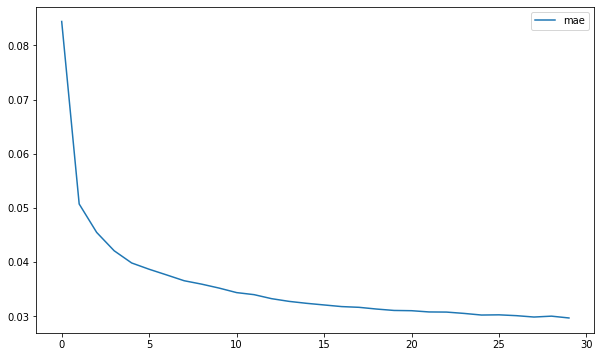

In [22]:

# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
#plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show() 

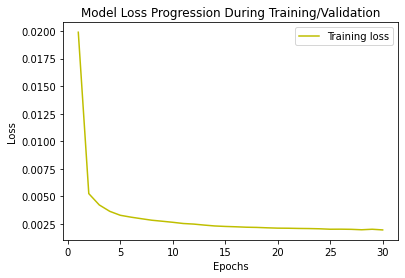

In [23]:
loss= history.history['loss']

epochs=range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training loss')

plt.title('Model Loss Progression During Training/Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

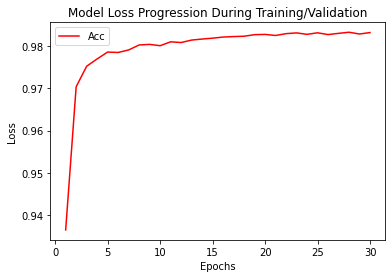

In [24]:

accuracy=history.history['accuracy']
epochs=range(1,len(loss)+1)
plt.plot(epochs,accuracy, 'r', label='Acc')
plt.title('Model Loss Progression During Training/Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [25]:
validation_x[0].shape

(10, 5)

In [26]:
validation_x.shape
test_data = np.reshape(validation_x[0],(1, validation_x[0].shape[0], validation_x[0].shape[1]))

In [27]:
v = X_test[11:]
v.shape

(43037, 5)

In [28]:
test = model.predict(test_data)
test

1/1 [==============================] - 0s 30ms/step


array([[0.58283734, 0.8103199 ]], dtype=float32)

In [29]:
trainPredict.shape

(129133, 2)

In [30]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.04 RMSE
Test Score: 0.04 RMSE


In [31]:
#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  
  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) : 
    pred[iter] = pred[iter] - 100  
    if abs(pred[iter]) >= 5:
      pred[iter] = 0 
  

  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
    pred[iter] = 100 - pred[iter]
    if abs(pred[iter]) >= 5:
        pred[iter] = 100

  

  

  #if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [32]:
#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


In [33]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [34]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

32699
43037
Precision  1 :  75.97880893184934
41149
43037
Precision  2 :  95.61307711968772
42730
43037
Precision  3 :  99.28666031554243
42989
43037
Precision  4 :  99.88846806236494
43035
43037
Precision  5 :  99.99535283593187


In [35]:
# linspace
#rv = multivariate_normal ([0,0],[1,.5],[.5,1])
# Z = rv,pdf(pos)
# contour(x,y,z)

In [36]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)

Predicting Percentage RMSE:  0.9339011825045235


In [37]:
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

43037
43037
0.9339011825045247


Text(0, 0.5, 'Percentage (%)')

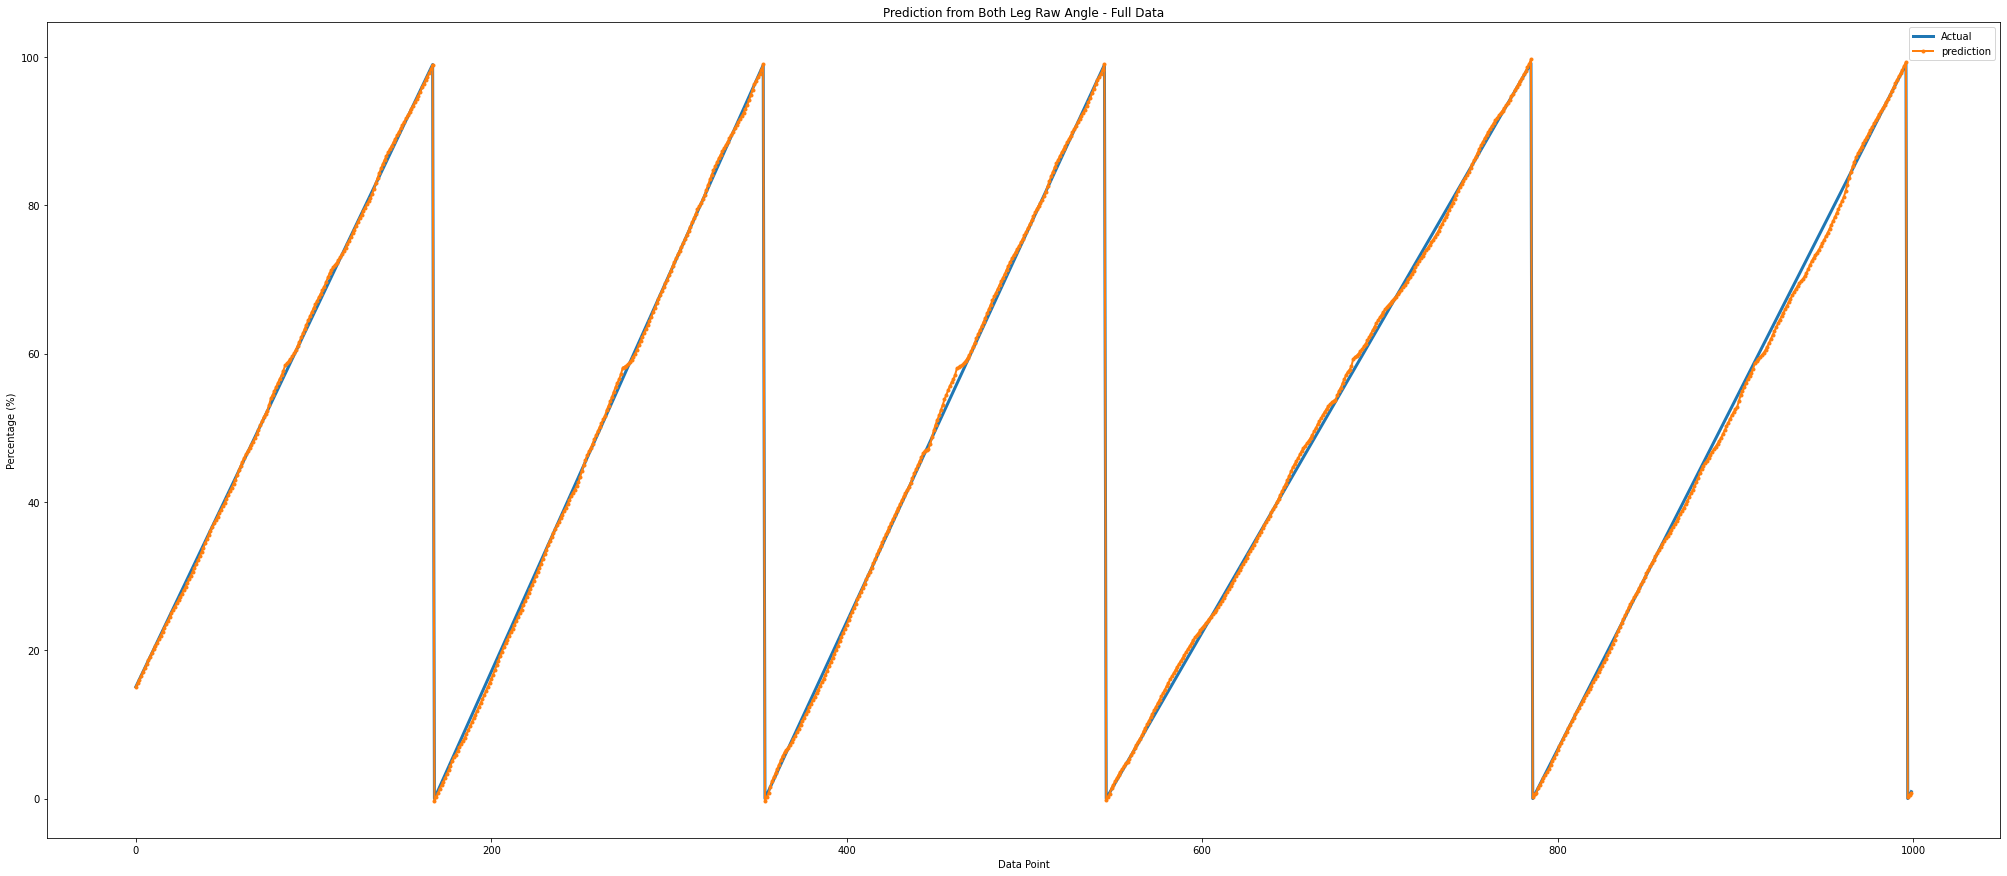

In [38]:
#plt.plot(Y[52272:52470],LShank[52272:52470],'--',label='Actual')
#plt.plot(pred,LShank,'--',label='prediction')
fig=plt.figure(figsize=(35,15))

plt.plot(actual[0:1000],'-',label='Actual', linewidth = 3)
plt.plot(pred[0:1000],'.-',label='prediction', linewidth = 2)



#plt.plot(actual[350:556],Rfoot[350:556],'.',label='Actual')
#plt.plot(pred[350:556],Rfoot[350:556],'.',label='prediction')

plt.legend()
plt.title('Prediction from Both Leg Raw Angle - Full Data')
#plt.title('Right Foot')
#plt.ylabel('Angle')
#plt.xlabel('Gait Cycle Percentage')
plt.xlabel('Data Point')
plt.ylabel('Percentage (%)')

Text(0.5, 1.0, 'Actual vs Prediction')

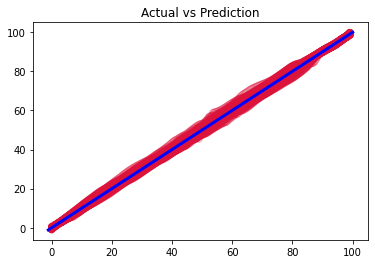

In [39]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

In [40]:
#predict = np.zeros((len(test_new),1))

#for iter in range(len(test_new)):
#  x = test_new[iter][0]
#  y = test_new[iter][1]
#  predict[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


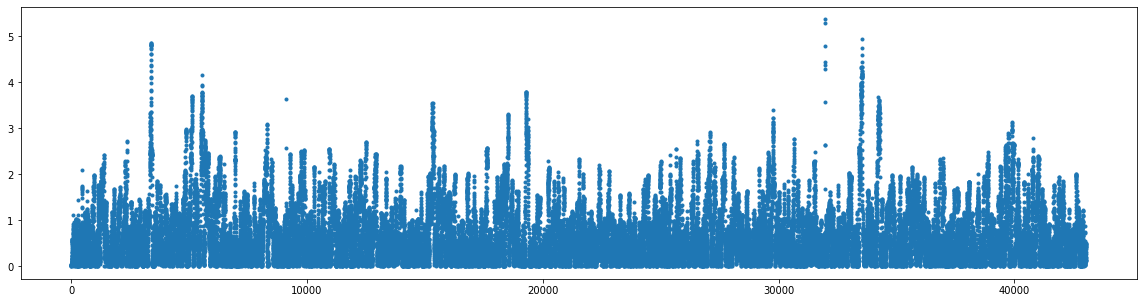

In [41]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual-pred)

plt.plot(dif,'.')


In [42]:
data_dif = pd.DataFrame(pred)
print(data_dif.to_string())

                0
0       15.076038
1       15.555714
2       16.043171
3       16.540674
4       17.053454
5       17.576023
6       18.104658
7       18.633282
8       19.152973
9       19.653877
10      20.126809
11      20.577066
12      21.018347
13      21.485019
14      21.983857
15      22.515623
16      23.020517
17      23.499123
18      23.969238
19      24.453844
20      24.964834
21      25.444453
22      25.896298
23      26.336651
24      26.767990
25      27.202735
26      27.652912
27      28.116663
28      28.577973
29      29.058673
30      29.564839
31      30.079365
32      30.595018
33      31.114211
34      31.618563
35      32.123816
36      32.674466
37      33.259230
38      33.848788
39      34.440779
40      35.024984
41      35.585648
42      36.123780
43      36.635426
44      37.121677
45      37.581881
46      38.039317
47      38.503723
48      38.972514
49      39.439125
50      39.893107
51      40.375637
52      40.898804
53      41.422882
54      41

In [43]:
act_dif = pd.DataFrame(actual)
print(act_dif.to_string())

               0
0      15.075377
1      15.577889
2      16.080402
3      16.582915
4      17.085427
5      17.587940
6      18.090452
7      18.592965
8      19.095477
9      19.597990
10     20.100503
11     20.603015
12     21.105528
13     21.608040
14     22.110553
15     22.613065
16     23.115578
17     23.618090
18     24.120603
19     24.623116
20     25.125628
21     25.628141
22     26.130653
23     26.633166
24     27.135678
25     27.638191
26     28.140704
27     28.643216
28     29.145729
29     29.648241
30     30.150754
31     30.653266
32     31.155779
33     31.658291
34     32.160804
35     32.663317
36     33.165829
37     33.668342
38     34.170854
39     34.673367
40     35.175879
41     35.678392
42     36.180905
43     36.683417
44     37.185930
45     37.688442
46     38.190955
47     38.693467
48     39.195980
49     39.698492
50     40.201005
51     40.703518
52     41.206030
53     41.708543
54     42.211055
55     42.713568
56     43.216080
57     43.7185

In [44]:
for i in range(len(pred)):
    if (abs(actual[i]-pred[i]) > 50):
        print(i)

In [45]:
strike = pd.DataFrame(x_test[:,-1])
print(strike.to_string())

           0
0       31.0
1       32.0
2       33.0
3       34.0
4       35.0
5       36.0
6       37.0
7       38.0
8       39.0
9       40.0
10      41.0
11      42.0
12      43.0
13      44.0
14      45.0
15      46.0
16      47.0
17      48.0
18      49.0
19      50.0
20      51.0
21      52.0
22      53.0
23      54.0
24      55.0
25      56.0
26      57.0
27      58.0
28      59.0
29      60.0
30      61.0
31      62.0
32      63.0
33      64.0
34      65.0
35      66.0
36      67.0
37      68.0
38      69.0
39      70.0
40      71.0
41      72.0
42      73.0
43      74.0
44      75.0
45      76.0
46      77.0
47      78.0
48      79.0
49      80.0
50      81.0
51      82.0
52      83.0
53      84.0
54      85.0
55      86.0
56      87.0
57      88.0
58      89.0
59      90.0
60      91.0
61      92.0
62      93.0
63      94.0
64      95.0
65      96.0
66      97.0
67      98.0
68      99.0
69     100.0
70     101.0
71     102.0
72     103.0
73     104.0
74     105.0
75     106.0

In [46]:
x_test[18604][:]

array([3.12923804e-01, 9.30317928e-01, 2.05620849e-05, 4.52133823e-01,
       3.20000000e+01])

In [47]:
print('Predict: ', pred[18604])
print('Actual: ', actual[18604])

Predict:  [15.03851286]
Actual:  [16.14583333]


In [48]:
dif[18604]

array([1.10732047])